In [ ]:
# install necessary geospatial packages

!pip -q install rasterio
!pip -q install fiona
!pip -q install geopandas
!pip -q install pycrs
!pip -q install descartes 
!pip -q install pypng
!pip -q install rtree
!pip -q install pygeos

#Built in breakpoint function Not sure how it works yet
import pdb; 


     |████████████████████████████████| 19.3 MB 7.1 MB/s 
     |████████████████████████████████| 16.7 MB 8.4 MB/s 
     |████████████████████████████████| 1.0 MB 7.2 MB/s 
     |████████████████████████████████| 6.3 MB 56.5 MB/s 
     |████████████████████████████████| 48 kB 3.6 MB/s 
     |████████████████████████████████| 994 kB 8.2 MB/s 
     |████████████████████████████████| 2.1 MB 8.3 MB/s 


In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

 # necessary basic libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import png
import re
import time
import glob

# geospatial libraries
import rasterio
import geopandas
from geopandas.tools import sjoin
import fiona
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import descartes
import pygeos
import rtree

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
# Filepath to tiff that you want to read
tiff_filepath = '/content/drive/MyDrive/forestseg/paracou_data/imagery/RGB_Broad_Mosaics/Paracou_20220106_RGB_5cm_mosa_rect.tif'
# Filepath to Read in shapefile of crowns, if training on your own data!
manuallabels_filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/220303_AllSpLabelled.gpkg'

#Filepath to csv containing the origin x and y coordinates of the tiles you wish to slice up...
csvfile_filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/training_tiles_paracu_broad_mosaics_50.csv'
#
save_tiff_filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/tilestraining/tiffs'

#
save_png_filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/tilestraining/pngs'
save_geojson_filepath = '/content/drive/MyDrive/forestseg/paracou_data/Panayiotis_Outputs/tilestraining/pngs'


In [ ]:
#   os.mkdir(path)
#   os.makedirs(path)  
#newpath = r'C:\Program Files\arbitrary' 
#if not os.path.exists(newpath):
#   os.makedirs(newpath)

# All files and directories ending with .txt and that don't begin with a dot:
#print(glob.glob("/home/adam/*.txt")) 
# All files and directories ending with .txt with depth of 2 folders, ignoring names beginning with a dot:
#print(glob.glob("/home/adam/*/*.txt")) 

#os.path.abspath("mydir/myfile.txt")

#Filepath with all the imagery


'/content/drive/MyDrive/forestseg/paracou_data/imagery/RGB_Broad_Mosaics/Paracou_20201105_RGB_5cm_mosa_rect.tif'

In [ ]:
### let's first read in the data.
### Firstly the tiff file of our area of interest, secondly our shapefile of manually delineated crowns, 
### if we are training the model rather than simply using a pre-trained model.

# Read in a tiff file
data = rasterio.open(tiff_filepath)

# Read in shapefile of crowns, if training on your own data!
crowns = geopandas.read_file(manuallabels_filepath)

# have a look at the crowns if we like
crowns.head(3)


,Site,PlotOrg,PlotNum,SubPlot,LocalID,CensusYear,CodeAlive,Family,Genus_Species,Genus,...,StartDate,EndDate,GroundValid,Creator,Comments,BaseLayer,IDStatus,DBHest,CheckJB,geometry
0,Paracou,CIRAD,1.0,1.0,637.0,2020.0,True,Fabaceae,Recordoxylon_speciosum,Recordoxylon,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"MULTIPOLYGON (((285161.966 583001.529, 285162...."
1,Paracou,CIRAD,1.0,1.0,829.0,2020.0,True,Lauraceae,Licaria_cannella,Licaria,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"MULTIPOLYGON (((285195.642 583006.243, 285194...."
2,Paracou,CIRAD,1.0,1.0,832.0,2020.0,True,Vochysiaceae,Qualea_rosea,Qualea,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"MULTIPOLYGON (((285188.628 583015.046, 285188...."


In [ ]:
crowns_polygon = crowns.explode('geometry',index=False)
crowns_polygon.head(3)
#R.geometry[1133]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


,,Site,PlotOrg,PlotNum,SubPlot,LocalID,CensusYear,CodeAlive,Family,Genus_Species,Genus,...,StartDate,EndDate,GroundValid,Creator,Comments,BaseLayer,IDStatus,DBHest,CheckJB,geometry
0,0,Paracou,CIRAD,1.0,1.0,637.0,2020.0,True,Fabaceae,Recordoxylon_speciosum,Recordoxylon,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"POLYGON ((285161.966 583001.529, 285162.016 58..."
1,0,Paracou,CIRAD,1.0,1.0,829.0,2020.0,True,Lauraceae,Licaria_cannella,Licaria,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"POLYGON ((285195.642 583006.243, 285194.484 58..."
2,0,Paracou,CIRAD,1.0,1.0,832.0,2020.0,True,Vochysiaceae,Qualea_rosea,Qualea,...,None,None,True,R_Dutrieux,None,MNC_2015,NaN,None,NaN,"POLYGON ((285188.628 583015.046, 285188.476 58..."


In [ ]:
FilePathSplit = tiff_filepath.split("/")
FileName = FilePathSplit[-1]

#Also need this without the '.tif'
FileNameSave = FileName.split(".tif")
FileNameSave = FileNameSave[0]
#print(FileNameSave)

#Extract Resolution Information from imagery
Resolution = re.search('(?!RGB_)\d+(?=cm_)', FileName)
Resolution = Resolution.group(0)
#Extract Date from imagery
Date = re.search('([0-9])\d+', FileName)
Date = Date.group(0)

#date1 = "31/12/2015"
#You can do the following:
#newdate1 = time.strptime(date1, "%d/%m/%Y")

DateImage = time.strptime(Date, "%Y%m%d")
#Make comparisons
print(DateImage)
for i in reversed(range(np.size(crowns.StartDate))):
  if crowns.StartDate[i] == None:
    continue
  else:
    print("StartDate ",i," ",crowns.StartDate[i])
    TreeStartDate = time.strptime(crowns.StartDate[i], "%Y-%m-%d")
    if DateImage >= TreeStartDate:
      continue
    else:
      crowns.drop(i)
      print('dropped ',i)


for i in reversed(range(np.size(crowns.EndDate))):
  if crowns.EndDate[i] == None:
    continue
  else:
    print("EndDate", i," ",crowns.EndDate[i])
    TreeEndDate = time.strptime(crowns.EndDate[i], "%Y-%m-%d")
    if DateImage <= TreeEndDate:
      continue
    else:
      crowns.drop(i)
      print('dropped ',i)
      
#Just need to check the above are correct

time.struct_time(tm_year=2022, tm_mon=1, tm_mday=6, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=6, tm_isdst=-1)
StartDate  3119   2020-10-23
StartDate  3116   2020-10-23
StartDate  3053   2021-03-03
StartDate  3039   2021-03-03
StartDate  2946   2020-10-23
StartDate  2681   2019-11-15
StartDate  2674   2019-11-15
StartDate  2668   2019-11-14
StartDate  2665   2019-11-15
StartDate  2664   2019-11-15
StartDate  2656   2019-11-15
StartDate  2627   2019-11-15
StartDate  2520   2019-11-15
StartDate  2515   2019-11-15
StartDate  2346   2019-11-15
StartDate  2345   2019-11-15
StartDate  1701   2019-11-15
EndDate 3120   2021-03-03
dropped  3120
EndDate 3118   2020-10-23
dropped  3118
EndDate 3117   2020-10-23
dropped  3117
EndDate 2839   2020-10-23
dropped  2839
EndDate 2714   2021-08-02
dropped  2714
EndDate 2669   2019-11-15
dropped  2669
EndDate 2614   2020-01-23
dropped  2614
EndDate 2549   2021-03-03
dropped  2549
EndDate 2231   2019-11-15
dropped  2231
EndDate 1895   2019-11-15
dro

In [ ]:
#import re
#m = re.search('(?<=abc)def', 'abcdef')
#m.group(0)

In [ ]:
# let's investigate the tiff, what is the shape? Bounds? Bands? CRS?
# show a plot of it too

print('shape =', data.shape,',', data.bounds, 'and number of bands =', data.count, ',crs =', data.crs)

# have a look if you want (usually slow)
# show(data)

shape = (24831, 34057) , BoundingBox(left=286176.3713277322, bottom=583359.3554560514, right=287505.6160377322, top=584328.5093860514) and number of bands = 3 ,crs = EPSG:32622


#### Looping through a set of tiles, to chop up the tiffs and crowns, and save as PNGs and GeoJSONs 

In [ ]:
# just defining a function we are going to use shortly.

def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        return [json.loads(gdf.to_json())['features'][0]['geometry']]

286400 583762


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286400 583662


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286559 583854


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2306)
286748 583830


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286716 583929


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286818 583948


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
287000 583744


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2306)
287153 583851


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286952 583994


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2307)
286918 584100


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2306)
287295 584130


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
287176 584157


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286302 583652


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286450 583762


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286450 583662


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286609 583854


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2307)
286798 583830


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286766 583929


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
286868 583948


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2306)
287050 583744


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287050_583744
287203 583851


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
287002 583994


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286968 584100
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

287345 584130
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

287226 584157
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286352 583652
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286400 583812
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286400_583812
286400 583712


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286559 583904
Array Shape
(3, 2307, 2306)
Empty of Training Data tile_286559_583904
286748 583880


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286716 583979
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286716_583979
286818 583998


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286818_583998
287000 583794


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2306)
Empty of Training Data tile_287000_583794
287153 583901


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287153_583901
286952 584044


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286918 584150
Array Shape
(3, 2307, 2306)
Empty of Training Data tile_286918_584150
287295 584180


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287295_584180
287176 584207


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287176_584207
286302 583702


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286450 583812
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286450_583812
286450 583712


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286609 583904
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286609_583904
286798 583880


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286766 583979
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_286766_583979
286868 583998


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2306)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

287050 583794
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287050_583794
287203 583901


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287203_583901
287002 584044


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2306, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

286968 584150
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

287345 584180
Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order c

287226 584207
Array Shape
(3, 2307, 2307)
Empty of Training Data tile_287226_584207
286352 583702


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Array Shape
(3, 2307, 2307)


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


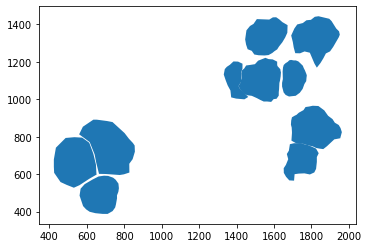

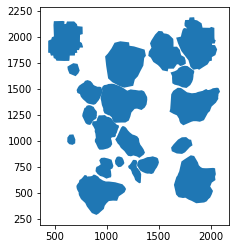

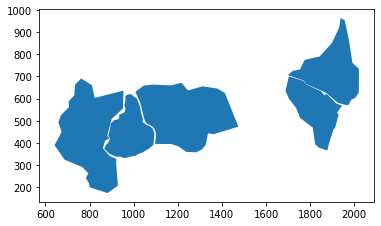

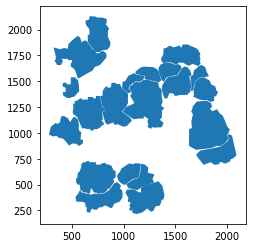

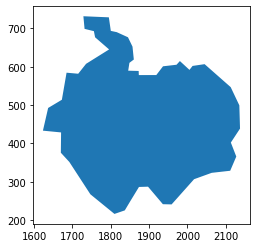

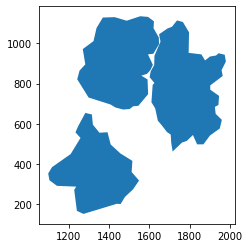

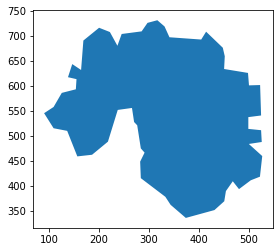

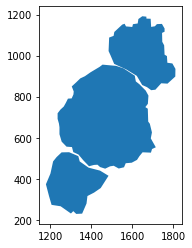

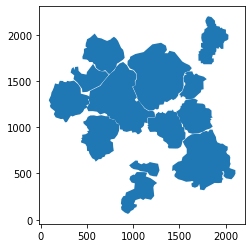

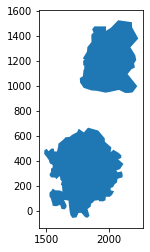

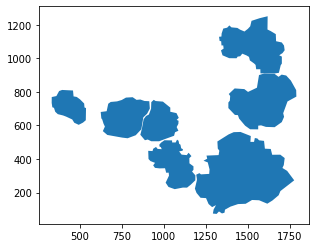

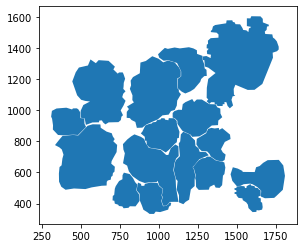

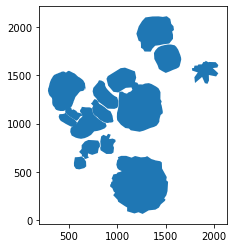

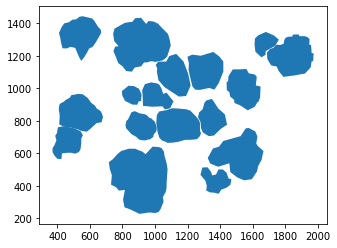

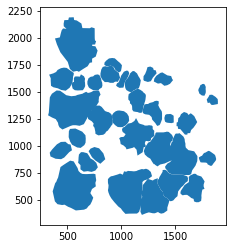

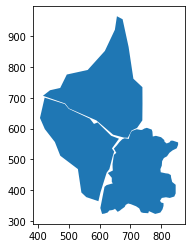

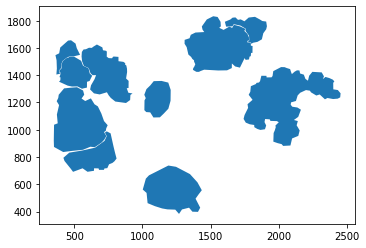

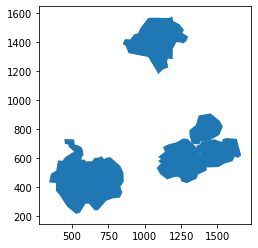

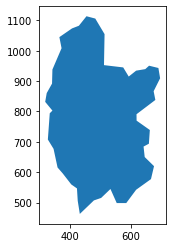

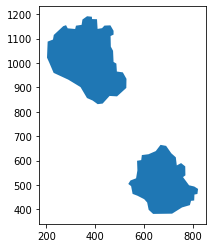

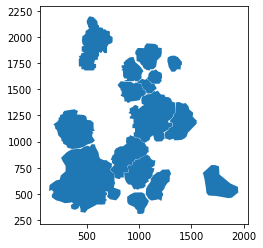

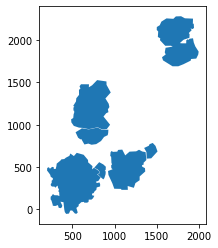

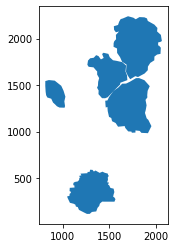

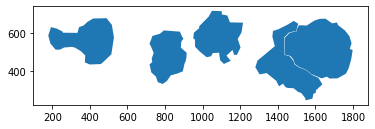

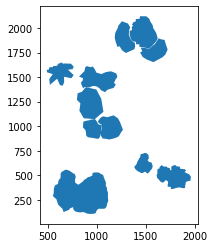

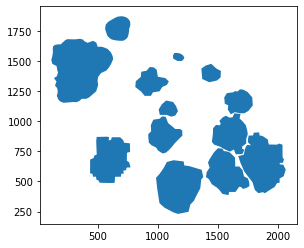

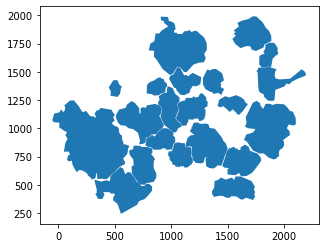

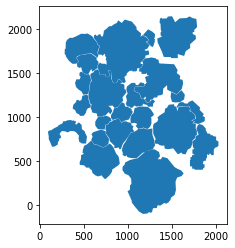

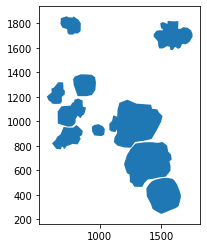

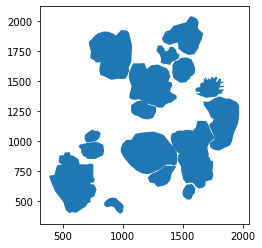

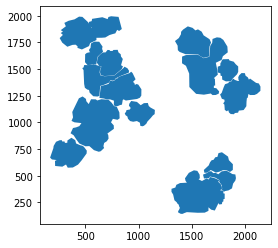

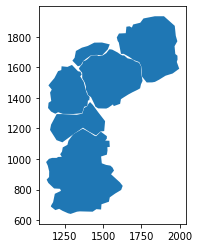

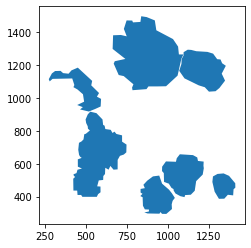

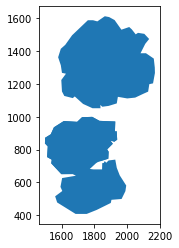

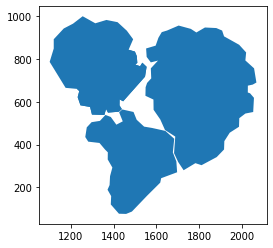

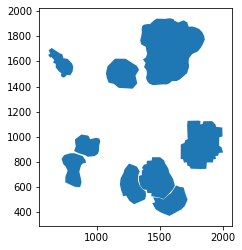

In [ ]:
# Read in a tiff file, and the csv of the tiles we expect
data = rasterio.open(tiff_filepath)

# Read in the shapefile of manual crowns - again, this is only if you are wanting to train with your own crowns

crowns = geopandas.read_file(manuallabels_filepath)

# read in a csv containing the origin x and y coordinates of the tiles you wish to slice up...
# this file can be commented out and replaced by looping over x and y coordinates as below

tiles = pd.read_csv(csvfile_filepath)

# set the desired buffer, tile width, heght and resolution of the tiff tiles. Suggested values are given below. 
# The buffer will be affected by the area of tree crowns in your region of forest.

buffer = 20
tile_width = 50
tile_height = 50
# moved
#resolution = 0.039 # in metres per pixel
#scaling = 1/resolution  # scaling parameter to transform the shapefile coordinates so they match the png


# the for loop can be rewritten to work with out requiring a csv e.g. for minx in range(V, W, step): e.g.:
#for minx in range(286900,286950,tile_width):
 # for miny in range(584000,584050,tile_height):
   
    

for ind in tiles.index:
    minx = tiles['Origin X coordinate'][ind] 
    miny = tiles['Origin Y coordinate'][ind]
    print(minx,miny)
    RejectImage = False
    # define the bounding box of the whole tile, including the buffer
    bbox = box(minx-buffer, miny-buffer, minx+tile_width+buffer, miny+tile_height+buffer)
    # define the bounding box of the tile, excluding the buffer (hence selecting just the central part of the tile)
    bbox_central = box(minx, miny, minx+tile_width, miny+tile_height)
    # turn the bounding boxes into geopandas DataFrames, need to set the crs
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32622))
    geo_central = gpd.GeoDataFrame({'geometry': bbox_central}, index=[0], crs=from_epsg(32622))
    #print(geo_central)

    ### here we are cropping the tiff to the bounding box of the tile we want
    coords = getFeatures(geo)
    #print(coords)
    
    # define the tile as a mask of the whole tiff with just the bounding box
     
    out_img, out_transform = mask(data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    #print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    #print(epsg_code)
    
    # update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform
                     })
    
    # here we are saving the tile as a new tiff, named by the origin of the tile
    out_tif = save_tiff_filepath + '/tile_' + str(minx) + '_' + str(miny) + '.tif'
    with rasterio.open(out_tif, "w", **out_meta) as dest:
                       dest.write(out_img)
    #plt.imshow(out_tif)
    # read in the tile we have just saved
    clipped = rasterio.open(save_tiff_filepath + '/tile_' + str(minx) + '_' + str(miny) + '.tif')
    # read it as an array
    arr = clipped.read()
    
    # check the shape of the tile if you wish
    print('Array Shape')
    print(arr.shape)
    resolution = (2 * buffer + tile_height) / arr.shape[1]  # in metres per pixel if tile_height = tile_width
    scaling = 1/resolution  # scaling parameter to transform the shapefile coordinates so they match the png
    # each band of the tiled tiff is a colour!
    R = arr[0]
    G = arr[1]
    B = arr[2]
    
    # stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2
    
    rgb = np.dstack((B,G,R)) # BGR for cv2
    #rgb_rescaled = 255*rgb/65535 # scale the values of the bands if they are non-standard to range 0-255
    rgb_rescaled = rgb # usually rescaling is not required, but it depends on your tiff
    
    # Remove images that have less than 50% valid regions
    rgb_average = (rgb_rescaled[:,:,0].astype('uint16') + rgb_rescaled[:,:,1].astype('uint16')  + rgb_rescaled[:,:,2].astype('uint16') ) / 3.
    rgb_mask = np.where(rgb_average > 250, 1 , 0)
    NumerOfPixels = rgb_mask.sum()
    TotalPixels = rgb_mask.shape[0] * rgb_mask.shape[1]
    if NumerOfPixels > 0.5 * TotalPixels:
      RejectImage = True
    
    if RejectImage == False:
      # save this as jpg or png...we are going for png...again, named with the origin of the specific tile
      cv2.imwrite(save_png_filepath+'/tile_'+str(minx)+'_'+str(miny)+'.png', rgb_rescaled)
      
      ### now we have dealt with tiling the tiff, we want to deal with tiling the crowns...
      ### IF we have manual crowns we are going to use for training
      ### THEN uncomment the following 4 lines of code
      
      ### select the crowns that intersect the non-buffered central section of the tile using the inner join
      overlapping_crowns = sjoin(crowns_polygon, geo_central, how="inner")

      #print(overlapping_crowns)
      ### translate to 0,0 to overlay on png
      moved = overlapping_crowns.translate(-minx+buffer, -miny+buffer)  

      ### scale to deal with the resolution
      moved_scaled = moved.scale(scaling, scaling, origin=(0, 0))

      Geodf_moved_scaled = gpd.GeoDataFrame(geometry=gpd.GeoSeries(moved_scaled))
      overlapping_crowns.geometry = Geodf_moved_scaled.geometry
      # { imagePath = [...]} to be added to json
      if moved_scaled.empty == False:
      ### save as a geojson, a format compatible with detectron2, again named by the origin of the tile
        overlapping_crowns.plot()
        overlapping_crowns.to_file(driver = 'GeoJSON', filename= save_geojson_filepath + '/tile_'+str(minx)+'_'+str(miny)+'.geojson')
      else:
        print('Empty of Training Data tile_'+str(minx)+'_'+str(miny))

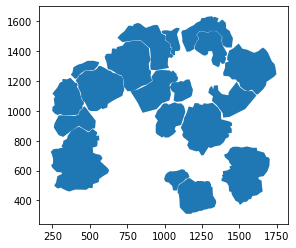

In [ ]:
overlapping_crowns = sjoin(crowns, geo_central, how="inner")
overlapping_crowns.head(2)
moved_scaled.plot()

In [ ]:
#
for i in range(np.size(crowns.StartDate)):
  if crowns.StartDate[i] == None:
    continue
  else:
    print(i," ",crowns.StartDate[i])

#
for i in range(np.size(crowns.EndDate)):
  if crowns.EndDate[i] == None:
    continue
  else:
    print(i," ",crowns.EndDate[i])

3032   2020-10-23
3125   2021-03-03
3139   2021-03-03
3202   2020-10-23
3205   2020-10-23
390   2019-11-15
1742   2019-11-15
1747   2019-11-15
1754   2019-11-15
1762   2019-11-15
1794   2019-11-15
1935   2019-11-15
1954   2019-11-15
2310   2019-11-15
2421   2019-11-15
2609   2019-11-15
2638   2021-03-03
2654   2020-10-23
2704   2020-01-23
2752   2019-11-15
2755   2019-11-15
2760   2019-11-15
2775   2019-11-15
2800   2021-08-02
2925   2020-10-23
3203   2020-10-23
3204   2020-10-23
3206   2021-03-03


46

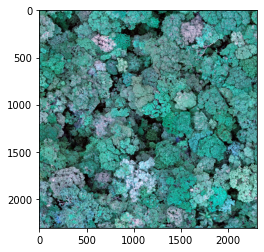

In [ ]:
#img = Image.fromarray(out_img, 'RGB')
#img = Image.fromarray(out_img)
#img.show()
#display(out_img)
#out_img.shape

#image = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
#display(Image.fromarray(image))
#image.shape
#out_img.shape
#type(out_img)




R = out_img[0]
G = out_img[1]
B = out_img[2]

# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2

rgb = np.dstack((B,G,R)) # BGR for cv2
#rgb_rescaled = 255*rgb/65535 # scale the values of the bands if they are non-standard to range 0-255
rgb_rescaled = rgb # usually rescaling is not required, but it depends on your tiff
plt.imshow(rgb_rescaled)
out_img
rgb.shape
rgb[0,0,0]

In [ ]:
np.size(crowns.StartDate)
i = 1
crowns.StartDate[i]